<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 4 - Spin-boson model

Throughout the first 3 tutorials, we have gradually come to see that a two state system (hereafter abbreviated to `TSS`) interacting with its environment can be modelled as a spin 1/2 particle in a magnetic field interacting with a quantised field of bosons.

In this tutorial we explore this `spin-boson` model (as it is often called) in more detail and in particular:
1.


In [4]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product

## 4.1 - Recap

Let's remind ourselves of the Hamiltonian that we built up in the last tutorial ([Tutorial 3](https://github.com/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb)):

$$H =  \overbrace{A \sigma_z}^{TSS}+ \overbrace{\hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right)}^{bosons} + \overbrace{\frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x}^{interaction}$$

The labels A and $\delta$ were chosen because of the path of discovery that we took to get here. From now on, it will be convenient for us to re-write the Hamiltonian with different labels as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise $\Delta E$ as the transition energy of the TSS, $\hbar\omega$ the energy of a single boson and $U$ as the strength of the interaction of the TSS with the boson field.

In the last tutorial we saw how the physics of spontaneous emission arose from an indirect coupling between the |+> and |-> states of the TSS which was mediated by the interaction with the boson field. This interaction manifested as a Rabi type oscillation between two states of the combined spin boson system (described by |n,±>), namely |0,+> and |1,->.

In general, the result of such interactions are far more complicated than the Rabi type oscillations we are becoming familiar with. We glimpsed this complexity last time when we observed that many bosons modes, with slightly different frequencies, interact with the TSS to produce an irregular pattern of state occupation probabilities. The complexity arises because the combined TSS and field system has many states that interact with each other strongly if their energies are similar.

We can however still apply the ideas we've learnt about TSS's in some special and interesting situations. That is what we'll explore in this notebook.

## 4.2 - Stationary states

We begin in the same way that we started this tutorial series ([Tutorial 1](https://github.com/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb)) by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.

To find the states of constant energy, we'll follow what we did in [Tutorial 2](https://github.com/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb). Specifically, we will calculate the eigenvalues of the Hamiltonian (i.e the energies) and see how they depend on the TSS transition energy $\Delta E$.

What do we expect to find? Recall that in Tutorial 2 (see Fig 3) we discovered an [avoided crossing](https://en.wikipedia.org/wiki/Avoided_crossing) (aka anti-crossing) when the transition energy of the TSS was zero  - this was due to the coupling between the states splitting the energy levels apart.

Let's see what we find in this more complicated spin-boson system - we'll start with no interaction $U=0$ to familiarsie ourselves with the landscape before exploring the full delights of the spin bosons system.

Since we will be creating many Hamiltonians with differing parameters, it's helpful to create a function to pre-compute the constant pieces.

In [5]:
def make_operators(max_bosons):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                         # two state system energy operator
    bosons       =  (a.dag()*a+0.5)                 # boson energy operator
    number        = a.dag()*a                       # boson number operator
    interaction  = (a.dag() + a) * sx               # interaction energy operator    

    
    return two_state, bosons, interaction, number

If we want to be 100% correct in our description of the spin-boson system, we should allow the possibility of an infinite number of bosons to be present. This is obviously not computationally feasible so we must choose a finite number for the maximum number of bosons we wish to consider.

For the sake of simplicity in visualisaion outputs, we choose a small number `max_bosons=4`.

In [44]:
max_bosons = 4
two_state, bosons, interaction, number = make_operators(max_bosons)

We now need to prepare a suitable data structure to hold the data about the energies of the stationary states. A [pandas dataframe](https://www.geeksforgeeks.org/python-pandas-dataframe/) (essentially a table) is a suitable choice (which makes plotting easier later).

We need to specify:
- number of rows - equal to the number of $\Delta E$ we wish to try
- number of columns - equal to the number of energy levels plus 1 to store the values of $\Delta E$
- column labels

Let's create another function for this and then look at an example:

In [45]:
def make_df_for_energy_scan(label_param, min_param, max_param, num_param, num_levels):
    
    # creates an empty dictionary to store the row/column information
    d = {}
    
    # creates array of parameter values that we want to scan through
    param_values = np.linspace(min_param, max_param, num_param)
    
    # stores the parameter scan label and values (this will soon become the first column in the dataframe)
    d[label_param] = param_values
    
    # creates empty columns to store the eigenvalues for the different levels later on
    # num_levels will be the number of rows of H or any of the operators that make up H
    for i in range(num_levels):
        d[f"level_{i}"] = np.zeros(num_param)
     
    # creates the dataframe
    df = pd.DataFrame(data=d)
    
    return df

In [46]:
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])
df.head()

,$\Delta E$,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9
0,-4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that we expect to calculate eigenvalues for 10 levels - these are associated with the 2 states from the TSS (|+>, |->) and 5 bosons states ($n= 0,1,2,3,4$) making $2\times5 = 10$ levels.

### 4.2.1 - Spin-boson landscape $U=0$

We're now ready to fill in the dataframe with the energy of the stationary sates by iterating over the rows using the [`iterrows`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) function.

Throughout this tutorial we will set $\omega=1$.

In [47]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

Because we stored the data in a dataframe, plotting is now easy.

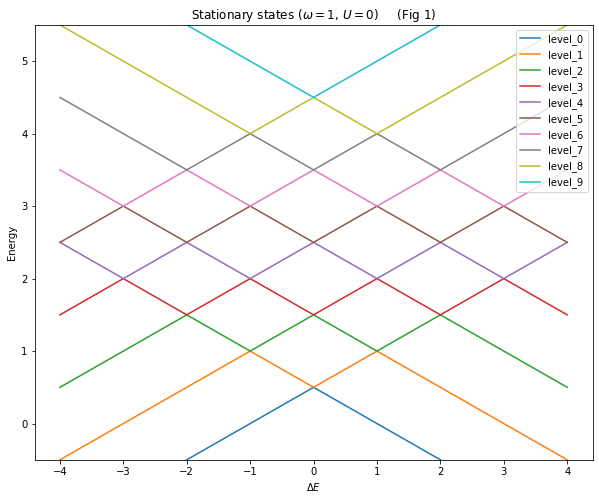

In [48]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title="Stationary states ($\omega=1$, $U=0$)     (Fig 1)");
plt.ylabel("Energy");

How do we understand Fig 1?

Start by focusing on where $\Delta E = 0$, i.e. there is no difference between the energies of the |+> and |-> states - this is the first thing we looked at back in Tutorial 1. There are several states/levels that appear to cross each other, they correspond to:
- orange/blue - 0 bosons (|0,±>)
- red/green - 1 boson (|1,±>)
- brown/purple - 2 bosons (|2,±>)
- grey/pink - 3 bosons (|3,±>)
- blue/yellow - 4 bosons (|4,±>)

Let's take the orange (|0,+>) and green (|1,->) lines. As we increase $\Delta E$, The energy of |0,+> goes up  and |1,-> goes down in energy. Eventually, these levels end up with the same energy despite having a different number of bosons - this is what allows the |0,+> couple strongly to |1,-> i.e. it's what makes possible the spontaneous emission we saw in the last tutorial. This particular crossing happens when $\Delta E = \omega = 1$, i.e. the resonance condition we first encountered in Tutorial 2. This is not the only resonance though. We can see there are many "non-primary" resonances at crossings when $\Delta E = \omega, 2\omega, 3\omega $ etc. We can therefore expect that when we switch the interaction on ($U\neq 0$) we will see the formation of anti-crossings similar to Tutorial 2.

In essence, we are now going to try and think about these crossings as if they are independent two state systems whose states and couplings we have to determine.

Let's see how we get on.


### 4.2.2 - Crossings and anti-crossings

We're now going to switch on the interaction term in the Hamiltonian. In order to more clearly visualise things, we will choose a stronger coupling than we did in the previous tutorial - specifically $U=0.2$.

In [49]:
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

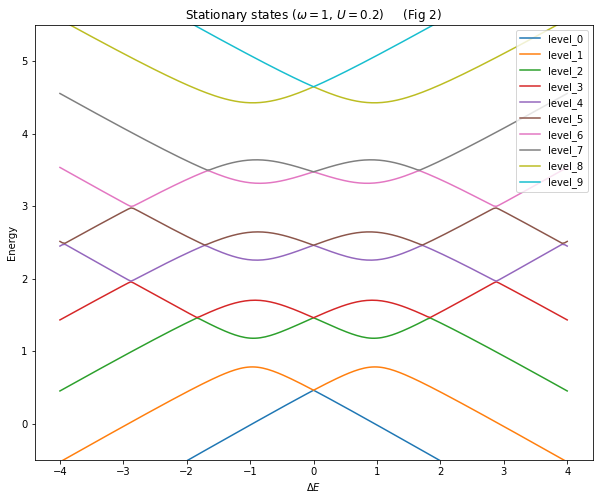

In [50]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

There are many things to say about what we see in Fig 2.

Two main features are:
1. the splitting of the levels increases with increasing level number i.e increasing number of bosons. 
2. not all crossings have been split apart into anti-crossings as we expected - this means some levels don't interact with each other at all. 

On 1. Applying our knowledge from Tutorial 1, we would say that the effective coupling between levels (which is proportional to the level splitting) increases with increasing boson number.

On 2. Upon closer inspection, we can see that the level splittings only occur when $\Delta E  \approx n \omega$ where n is an **odd** integer (we'll come to why we now use $\approx$ instead of = shortly). Although it is hard to see in Fig 2, if we zoom in on $\Delta E \approx 3\omega$ we can indeed see an anti-crossing.

To perform this zoom, it is best to perform a higher resolution scan of $\Delta E$:

In [51]:
df = make_df_for_energy_scan("$\Delta E$", 2.8, 2.95, 201, two_state.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

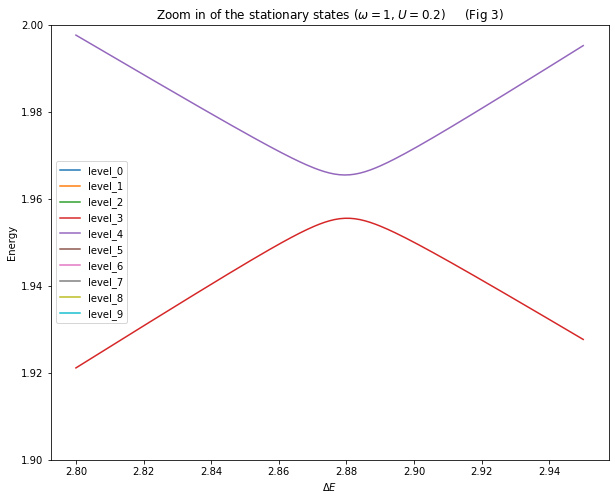

In [53]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[1.9,2],legend=True, 
        title="Zoom in of the stationary states ($\omega=1$, $U=0.2$)     (Fig 3)");
plt.ylabel("Energy");





The level splitting seen in Fig 3 is much smaller than those seen in Fig 2 at the primary resonance ($\Delta E \approx \omega$). We can therefore say that the effective coupling between levels is much less for the non-primary resonances.

Fig 3 also shows us that the location of the resonance is somewhat shifted, i.e. the anti-crossing does not occur when $\Delta E = 3 \omega$ but instead $\Delta E \approx 3\omega$. This shift is known as the [Bloch-Siegert shift](https://en.wikipedia.org/wiki/Bloch-Siegert_shift) (see also [Cohen-Tannoudji](https://iopscience.iop.org/article/10.1088/0022-3700/6/8/007) and [Hagelstein](https://iopscience.iop.org/article/10.1088/0953-4075/41/3/035601)) and arises from the the effect of the interaction energy in the Hamiltonian ($E_{I}$). Specifically, the resonance condition should instead be written as $\Delta E + E_{I} = 3\omega$ and hence the value of $\Delta E$ needed for resonance is somewhat reduced. 

>TODO: Classical meaning of Bloch-Siegert shift

> TODO:Make referenced to dressed atom picture https://www.youtube.com/watch?v=k0X7iSaPM38 and https://ocw.mit.edu/courses/physics/8-422-atomic-and-optical-physics-ii-spring-2013/

We can more clearly see the splitting of the levels and shifting of the resonances by scanning through various values of the interaction strength $U$. Let's create an [animated gif](https://github.com/maxhumber/gif) to show this.

In [54]:
# NOTE: THIS CELL TAKES ABOUT 2 MIN TO RUN

dfs = []                        # This is hold the dataframes for each value of U
Us = np.linspace(0, 0.6, 40)    # This will give us 40 frames in our animation from U=0 to U=0.6
for U in Us:
    
    df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

    for i, row in df.iterrows():
        H =  row["$\Delta E$"]*two_state + 1*bosons + U*interaction
        evals, ekets = H.eigenstates()
        df.iloc[i,1:] = evals 
        
    dfs.append(df)

In [56]:
# Uses the gif library from https://github.com/maxhumber/gif
@gif.frame
def plot(df,j):
    df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=True, 
        title=f"Stationary states for $H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$     ($\omega=1$, $U={Us[j]:.3f}$) ");
    plt.ylabel("Energy");
    
    
frames = []
for j, df in enumerate(dfs):
    frame = plot(df, j)
    frames.append(frame)
gif.save(frames, "energy-levels.gif", duration=250)

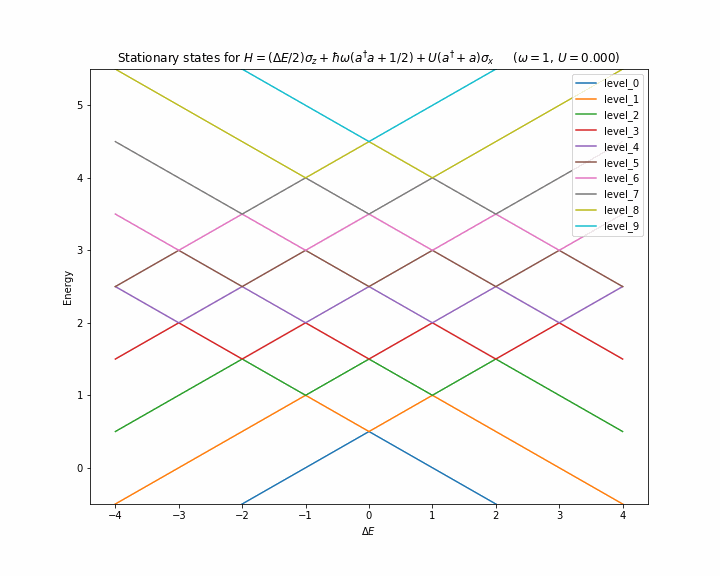

In [57]:
Image(filename="./energy-levels.gif")

Fig 3 also shows us something we haven't seen before. A resonance at $\Delta E \approx 3\omega$ suggests that it might be possible for the two state system transition to result in the emission of 3 smaller bosons rather than a single larger one. We'll investigate the possibility of this "down conversion" shortly.

In the meantime, let's try and understand why some levels don't couple to each other. For this we need to visualise the Hamiltonian. QuTiP offers a function called [`hinton`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=hinton#qutip.visualization.hinton) for just such a purpose.

We'll work with a Hamiltonian with a very large coupling of $U=1$ so that we'll be able to see things more clearly.

In [13]:
H = 1*two_state + 1*bosons + 1*interaction

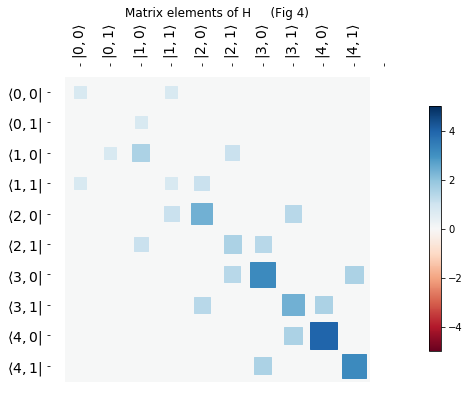

In [14]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 4)");

The colour and size of the squares in Fig 4 give you a measure of the how large different matrix elements are. The off diagonal elements arise solely from the interaction part of the Hamiltonian - this is what allows one state to (in a sense) "mutate" into another.

We'll study Fig 4 in more detail shortly, but for now I want to draw you attention to the labels for the rows and columns. For example, $|3, 0 \rangle$ represents 3 bosons and the two state system in the 0 state. The two state system numbers are handled somewhat confusingly in QuTiP, namely opposite to what you'd expect $0 \rightarrow +$ and $1\rightarrow -$. It will be helpful to have a way to map these QuTiP states to something more immediately recognisable, i.e. $|3, + \rangle$.

In [15]:
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [16]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

We can create some nice labels corresponding to the `nm_list`. This will make things like the hinton plot a lot easier to understand.

In [17]:
def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]
    return bra_labels, ket_labels

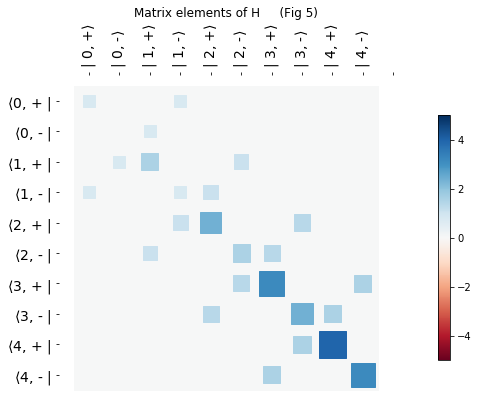

In [18]:
bra_labels, ket_labels = make_braket_labels(nm_list)

f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

That's better!

If we now take a closer look at the structure of the Hinton diagram we can see some interesting features when we follow a path that connects one state to another:

> TODO: Remake the parity.png picture with the correct value of U

                Matrix elements of H     (Fig 6)


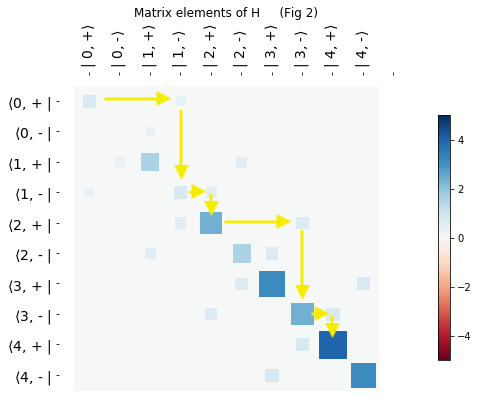

In [19]:
print("                Matrix elements of H     (Fig 6)")
Image(filename='parity.png') 

If we imagine starting a simulation with 0 bosons and the two state system in its + state, i.e. |0,+>, then Fig 6 suggests that:
1. there are connections (albeit indirect) from |0,+> to many different states with many more bosons, e.g. $|0,+> \rightarrow |1,-> \rightarrow |2,+> \rightarrow |3,-> \rightarrow |4,+> ...$.
2. there are some states that are not accessible at all if we start in the |0,+> state

On 1. These indirect connections provide a mechanism to achieve the down conversation that we saw hints of earlier.

On 2. The Hamiltonian appears to be composed of two separate "universes" that don't interact with each other. In our energy level diagram (Fig 2) both universes are present - perhaps if we separate them we'll only see anti-crossings in the respective plots.

What separates these universes is a form of [parity](https://en.wikipedia.org/wiki/Parity_%28physics%29). Parity is not particularly intuitive and a full discussion of it is somewhat involved and takes us deep into the topic of transition [selection rules](https://en.wikipedia.org/wiki/Selection_rule) - we'll come back to this another time.

For now, the the important thing to note is [how the parity operator $P$ acts on the system](https://iopscience.iop.org/article/10.1088/0305-4470/29/14/026):
- for the two state system $P |\pm> = \pm1|\pm> $, i.e. parity operator is the same as $\sigma_z$
- for [the field](https://ia801608.us.archive.org/11/items/TheParityOperatorForTheQuantumHarmonicOscillator/partity_article.pdf) with $n$ bosons $P |n> = -1^n |n>$, i.e. the parity is $-1^n = e^{i\pi n}$ 

Note, that we can use QuTiP's [`expm`](http://qutip.org/docs/latest/apidoc/classes.html#qutip.Qobj.expm) function to create the exponential operator from the number operator $n = a^{\dagger}a$. The combined parity is made by multiplying the two together. Let's see this in action:

In [20]:
sz = 2*two_state                 # recall we set Delta_E=1 for this example so two_state = 1/2*s_z
P = sz*(1j*np.pi*number).expm()

Creating a hinton diagram for the parity operator is revealing:

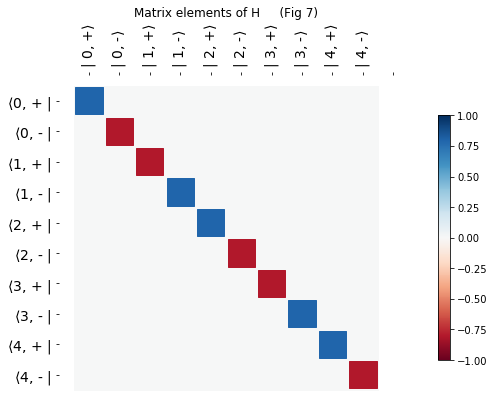

In [21]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 7)");

In Fig 7, we see that the the blue squares (parity=+1, often called even) matches up with the path of the yellow arrows in Fig 6. It is suggesting that if we start on a blue/red square then we remain on a blue/red square.

To check this, we need to look at the [`commutator`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.operators.commutator) between the Hamiltonian and parity:

In [22]:
commutator(H,P)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

A [zero commutator with H](https://youtu.be/eZ2UKJqLs4M) tells us that parity is conserved as the system evolves.

We can therefore break up the description of our system into two universes based on whether the states have even (+1) parity or odd (-1) parity.

Let's look at even parity manually before we create a function to handle separation of the parity universes.

First, we need to get the row/column numbers where we have parity = 1

In [23]:
even = np.where(P.diag()==1)[0]
even

array([0, 3, 4, 7, 8])

We can now use a QuTiP function called [`extract_states`](http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states) to only select the parts of the Hamiltonian that's of interest to us:

In [24]:
H_even = H.extract_states(even)

Before we have a look at the resulting Hinton diagram we must also extract the corresponding state labels |n,±>:

In [25]:
nm_list_even = [nm_list[i] for i in even]
nm_list_even

[(0, '+'), (1, '-'), (2, '+'), (3, '-'), (4, '+')]

In [26]:
bra_labels, ket_labels = make_braket_labels(nm_list_even)

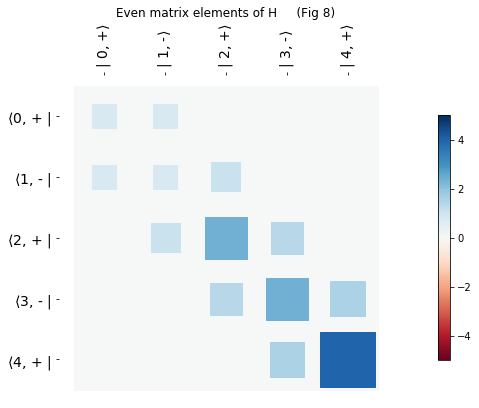

In [27]:
f, ax = hinton(H_even, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Even matrix elements of H     (Fig 8)");

Now with only a single parity, Fig 8 makes it easier to see how the system behaves - boson numbers can only go up by one each time and when they do the two state system must flip between \+> and |-> (the same is true for the odd universe).

It will be helpful for us to be able to handle the extraction of states and state labels in a more automatic way. Let's augment the `make_operators` function to do this:

In [28]:
def make_operators(max_bosons, parity):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                      # two state system energy operator
    bosons       =  (a.dag()*a+0.5)              # boson energy operator
    number        = a.dag()*a                      # boson number operator
    interaction  = (a.dag() + a) * sx            # interaction energy operator      
    
    P = sz*(1j*np.pi*a.dag()*a).expm()            # parity operator 
    
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

We are now in a position to compare the energy level plots for the different parity universes side by side.

In [29]:
# EVEN PARITY

two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

In [30]:
# ODD PARITY

two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

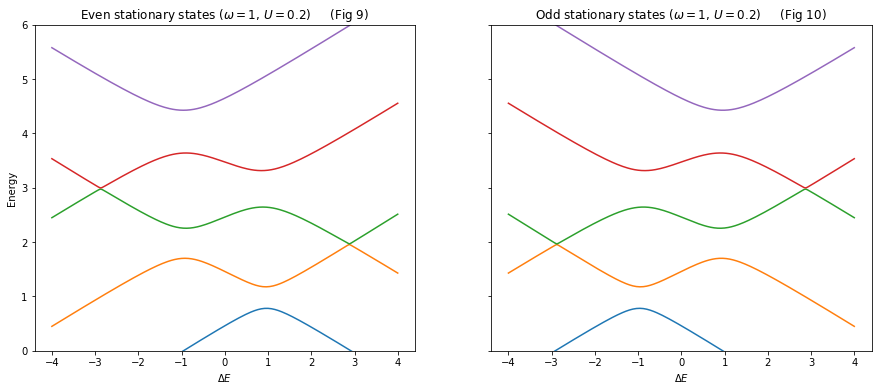

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_even.plot(x="$\Delta E$",ylim=[0,6],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.2$)     (Fig 9)",  ax=axes[0]);

df_odd.plot(x="$\Delta E$",ylim=[0,6],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.2$)     (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

Figs 9 and 10 show us the energy of the stationary states for the even and odd parity states respectively. As we expected, we now only see anti-crossings because in each universe there are no forbidden interactions.

Now we are in a position to explore some new physics - we predicted that when $\delta E \approx 3\omega$ (anti-crossing in Fig 9 and also Fig 3) we get down conversation? Let's simulate and see if we are correct.

In [33]:
# Create the operators and state list for even parity universe
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=1)

# Create the nice bra and ket labels for plots later
bra_labels, ket_labels = make_braket_labels(nm_list)

# Create the Hamiltonian corresponding to the anti-crossing we saw in Fig 3
H =  2.88*two_state + 1*bosons + 0.2*interaction

We also need to specify the initial condition for the state - we want this to be |0,+>. Previously we used the `tensor` function to make this, but now that we are working in the parity universe this doesn't work so easily.

Instead we will need to use `basis` function as we did at the very start of Tutorial 1. In order for this to be convenient, we need to make a function that takes as an input |n,±> and scans through our list of states to find which entry it corresponds to.

In [34]:
def index_from_nm(nm_list,n,m): 
    try:
        return [item for item in nm_list].index((n,m))
    except:
        print("ERROR: State doesn't exist")


In [35]:
i = index_from_nm(nm_list, 0, "+")  # Find which index corresponds to the |0,+> state
i

0

In [36]:
psi0 = basis(H.shape[0], i)

In [37]:
psi0

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]]

In the previous tutorials we have been using QuTiP's [`sesolve`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.sesolve) to simulate the system. `sesolve` solves the Schrödinger equation. This was convenient as for us when we were getting started - we only needed a single line of code to run the simulation. It was especially useful when we introduced a time dependent perturbation to our two state Hamiltonian in Tutorial 2. However, `sesolve` will cause us problems as we increase the number of bosons that we want to simulate - the simulation will take too long to run.

Technically, we don't actually need a special solver like `sesolve` when dealing with time-independent problems (like ours). The business of solving the Schrödinger equation can be reduced to a problem of finding the eigenvalues and eigenvectors of the Hamiltonian.

We'll not go into the details of how this works right now - head over to the appendix for that. For now, we'll just use the results to run some simulations.

In [38]:
def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    psi = np.zeros([num_states,times.size], dtype="complex128")
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi

In [39]:
times = np.linspace(0.0, 1000.0, 1000)
P, psi = simulate(H, psi0, times)

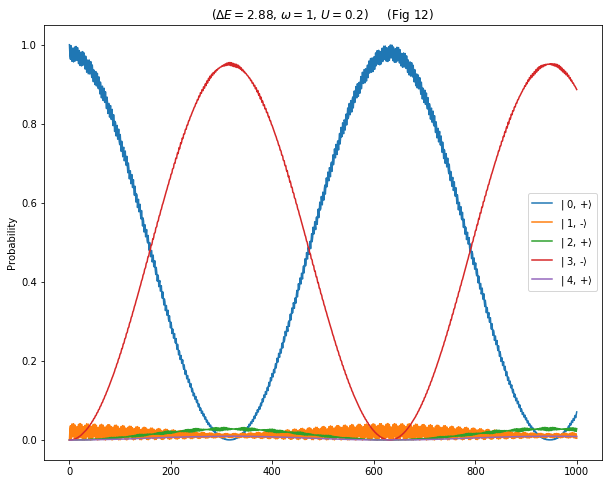

In [40]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.title("($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 12)")
plt.show();

Fig 12 shows us that our ideas were correct - the system starts off with bosons and transitions to a state with 3 at the expense of the two state energy. We can see this energy exchange explicitly by evaluating the expectation values of the various parts of the Hamiltonian.

QuTiP does allow us to do this using the [`expect`](http://qutip.org/docs/latest/guide/guide-states.html#expectation-values) function. However, it turns out that we need to create a `Qobj` for every time step in order to use this function and it can be very slow. We will instead directly calculate the expectation value using matrix multiplication, i.e.


$<H> = \psi^{\dagger}H\psi = \psi^{\dagger} @ (H @\psi) $

Where @ is the matrix multiplication operator and $\dagger$ in this context means taking the complex conjugate.

Let's automate this process for all time steps using a function.

In [41]:
def expectation(operator, states):
    operator_expect = []
    for i in range(0,shape(states)[1]):
        e = np.conj(states[:,i])@ (operator @ states[:,i])
        operator_expect.append(e)
    return operator_expect

We can now see how the different parts of the Hamiltonian change overtime

In [42]:
hamiltonian_expect = expectation(H,psi)
two_state_expect = expectation(2.88*two_state,psi)
bosons_expect = expectation(1*bosons,psi)
interaction_expect = expectation(0.2*interaction,psi)

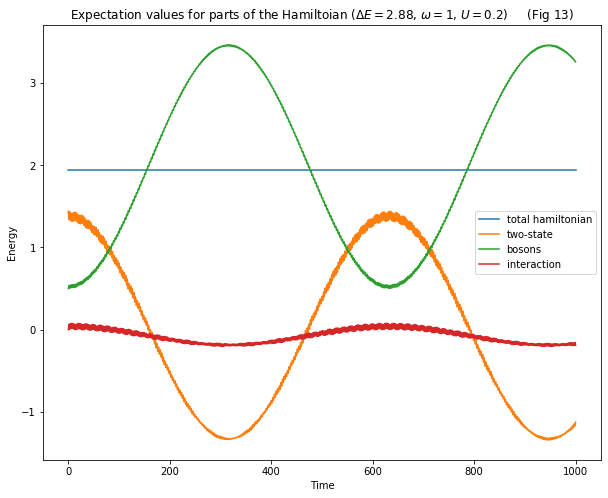

In [43]:
plt.figure(figsize=(10,8))
plt.plot(times, hamiltonian_expect, label="total hamiltonian")
plt.plot(times, two_state_expect, label="two-state")
plt.plot(times, bosons_expect, label="bosons")
plt.plot(times, interaction_expect, label="interaction")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for parts of the Hamiltoian ($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 13)")
plt.show();

We can indeed see in Fig 13 the energy exchange that we expect between the two state system and the bosons field. We can also see how the interaction energy is moving in sync with the two state energy - this is another way of seeing the "dressing" effect that we mentioned earlier.

## Next time...

We'll look at ...
- large n
- sensitivity of resonances
- interaction energy allows more bosons than you might expect, e.g. when $\Delta E =11 \omega$ we can have 11, or 13 or 15 or 17 bosons.

---

## Appendix - Solving the Schrödinger equation

In [44]:
# Create the operators and state list for even parity universe
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=4, parity=1)

# Create the nice bra and ket labels for plots later
bra_labels, ket_labels = make_braket_labels(nm_list)

# Create the Hamiltonian corresponding to the anti-crossing we saw in Fig 3
H =  2.88*two_state + 1*bosons + 0.2*interaction

In [45]:
i = index_from_nm(nm_list, 0, "+")  # Find which index corresponds to the |0,+> state
psi0 = basis(H.shape[0], i)

Let's see how it works and then go through an example:

1. Transform initial state $\psi_0$ into a new basis defined by the eigenvectors (aka eigenkets) of the Hamiltonian i.e. the states of constant energy (represented here by $|i>$)
  - $\psi_0 = \underset{i}{\Sigma}   <i|\psi_0> |i>$
  -  $<i|\psi_0> = $ `psi0.transform(ekets)[i]`
2. Evolve each part of the state according to its eigenfrequency (aka eigenvalues) $\omega_i$
  - $\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i>$
  - $\omega_i =$ `evals[i]`
3. Transform the evolved state back into the basis we started with (represented here by $|k>$)
  - $\psi (t)= \underset{i,k}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ <k|i>|k>$
  - $<k|i> = $ `ekets[i][k]`

Let's try it out.

**Step 1**:

In [46]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [47]:
psi0_in_H_basis

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[-1.03242717e-01]
 [ 6.97302743e-01]
 [ 7.09269873e-01]
 [ 6.78758529e-03]
 [ 4.16601830e-05]]

This way of representing $\psi_0$ shows us that at the anti-crossing $|0,+>$ is mainly a mixture of the 1st and 2nd energy states. QuTiP has a convenient way of visualising the probabilities associated with such a state using [`plot_fock_distribution`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=plot_fock_distribution#qutip.visualization.plot_fock_distribution)

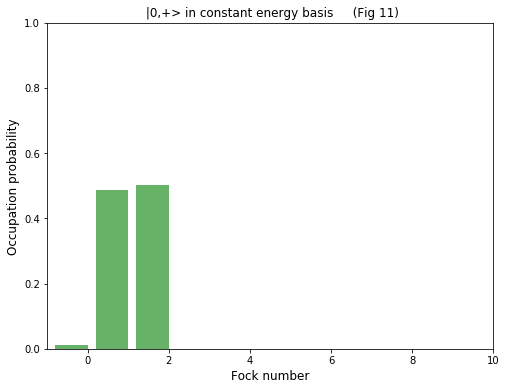

In [48]:
plot_fock_distribution(psi0_in_H_basis, title=f" |0,+> in constant energy basis     (Fig 11)")
plt.xlim(-1,10);

> TODO: FIX ALL THE NUMBERS

Continuing to follow the procedure, we have:

$\psi_0 = \underset{i}{\Sigma}  <i|\psi_0> |i> \\
\ \ \ \ = 0 |0> + 0.479 |1> + 0 |2> - 0.607 |3> ...$

**Step 2:**

The frequencies are given by the eigenvalues of the Hamiltonian:

In [49]:
evals

array([0.01846842, 1.95554692, 1.96549683, 4.01906122, 5.98142661])

and so (dropping the zero terms from step 1) the evolved state becomes:

$\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i> \\
\ \ \ \ =  0.479 e^{-i (-0.497)t}|1> +-0.607 e^{-i 0.837t} |3> ...$

**Step 3:**

Taking only the $|1>$ part form step 2 above for the sake of brevity, we only need to look at `ekets[1]`

In [50]:
ekets[1]

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[ 0.69730274]
 [ 0.05420454]
 [-0.1298011 ]
 [ 0.69932371]
 [-0.07020524]]

Then:

$0.479 e^{-i (-0.497)t}|1> \rightarrow 0.479 e^{-i (-0.497)t}0.479|0'> + 0.479 e^{-i (-0.497)t}(-0.754)|3'> + 0.479 e^{-i (-0.497)t}0.421|4'> ...$

where the prime in $|n'>$ indicates the original basis and not the energy basis. We can relabel these states to be the more familiar $|n,\pm>$ using the list we made earlier:

In [51]:
nm_list

[(0, '+'), (1, '-'), (2, '+'), (3, '-'), (4, '+')]

From this we see that:

$|0'> = |0,+>$,  

$|3'> = |1,->$ 

$|4'> = |2,+>$

and so we have:

$0.479 e^{-i (-0.497)t}|1> \rightarrow 0.479 e^{-i (-0.497)t}0.479|0,+>  + 0.479 e^{-i (-0.497)t}(-0.754)|1,-> + 0.479 e^{-i (-0.497)t}0.421|2,+> ...$

All of the above can be automated by making a function that we can reuse again and again:

```python
def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    psi = np.zeros([num_states,times.size], dtype="complex128")
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi
```